In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor

In [2]:
df_master = pd.read_csv("..\\Data_Sets\\processed\\completeData_1995-2022.csv")

In [3]:
# Converting boolean columns to integer
df_master = df_master.astype({col: 'int' for col in df_master.select_dtypes(['bool']).columns})

# predictors dataFrame
df_predictors = df_master.iloc[:,2:]
df_predictors = df_predictors.drop('GDP per capita (current USD)', axis=1)

# Dealing with Multicollinearity

In [4]:
# Computing correlation matrix
correlation_matrix = df_predictors.corr()

# Identifying pairs of features with high correlation coefficients (greater than 0.7 in absolute value)
highly_correlated_pairs = {}
for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if idx == col:
            continue
        if abs(correlation_matrix.loc[idx, col]) > 0.7:
            pair = tuple(sorted([idx, col]))
            if pair not in highly_correlated_pairs:
                highly_correlated_pairs[pair] = correlation_matrix.loc[idx, col]

# Convert the dictionary to a DataFrame for better display
df_highlyCorrelated = pd.DataFrame(list(highly_correlated_pairs.items()), columns=["Feature Pair", "Correlation Coefficient"])

df_highlyCorrelated

,Feature Pair,Correlation Coefficient
0,"(Government Integrity, Property Rights)",0.848972
1,"(Judicial Effectiveness, Property Rights)",0.713712
2,"(Business Freedom, Property Rights)",0.728501
3,"(Financial Freedom, Investment Freedom)",0.747306
4,"(Human Development Index, Under-5 mortality ra...",-0.864344
5,"(isLandLocked, n_accessToSea)",-0.902937
6,"(Amount of Ports, Expanded EconZone Area)",0.710652
7,"(Amount of Ports, H index (Academic Papers))",0.794973
8,"(Amount of Ports, Migration Volume)",0.764736
9,"(Average Temperature (C), Distance from Equator)",-0.857508


Based on the results above, we'll delete Average Temperature (C), isLandLocked, Under-5 mortality rate (per 1k live births) as they all have more than 0.85 absolute correlation.

There are other high-correlation pairs [like (Government Integrity, Property Rights) and (Amount of Ports, H index (Academic Papers))]. The first one we'll keep as we're trying to predict GDP using mainly Economic Freedom. The later (and others like it) we'll keep as they are from unrelated subjects.

In [5]:
df_master = df_master.drop(['Average Temperature (C)', 'isLandLocked', 'Under-5 mortality rate (per 1k live births)'], axis=1)

# Regression Model:

In [6]:
# Creating dummy variables for each country to account for fixed effects
data_dummies = pd.get_dummies(df_master, columns=["Country Name"], drop_first=True)

X = data_dummies.drop(columns=["Index Year", "GDP per capita (current USD)"])
y = data_dummies["GDP per capita (current USD)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

yHat = lr.predict(X_test)

mse = mean_squared_error(y_test, yHat)
r2 = r2_score(y_test, yHat)

mse, r2

18008235.078458503

### Polynomial Regression + Ridge
Using dummies for countries with polynomial is impractical in my system (as it adds 183 columns to the dataset).

In [8]:
# Creating dummy variables for each country to account for fixed effects
data_dummies = df_master.drop(columns=['Country Name'], axis=1)

X = data_dummies.drop(columns=["Index Year", "GDP per capita (current USD)"])
y = data_dummies["GDP per capita (current USD)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Building a pipeline
steps = [
    ('poly', PolynomialFeatures())
    # [I've tested ridge regularization. But it doesn't seem necessary in this dataset.]
]
pipeline = Pipeline(steps)

param_grid = {
    'poly__degree': [1, 2, 3]
}

# Initialize GridSearchCV with the pipeline and the hyperparameter grid
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid.fit(X_train, y_train)

# Get the best parameters and the corresponding mean squared error
best_params = grid.best_params_
best_mse = -grid.best_score_

best_params, best_mse


C:\Users\gusta\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.46972e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


({'poly__degree': 1, 'ridge__alpha': 10}, 49705347.45294566)

Let's check each of the parameters

Training Data

In [10]:
results_df = pd.DataFrame(grid.cv_results_)

# Extracting only the columns we need (params and mean_test_score)
results_df = results_df[['param_poly__degree', 'param_ridge__alpha', 'mean_test_score']]

# Pivot the DataFrame to create a matrix-like format
mse_matrix = results_df.pivot(index='param_poly__degree', columns='param_ridge__alpha', values='mean_test_score')

# Converting negative MSE to positive for visualization
mse_matrix = -mse_matrix

mse_matrix


param_ridge__alpha,1,10,20,30,50
param_poly__degree,,,,,
1,4.971738e+07,4.970535e+07,4.972225e+07,4.975454e+07,4.984600e+07
2,6.574939e+07,6.574939e+07,6.574939e+07,6.574939e+07,6.574939e+07
3,2.766868e+08,2.766868e+08,2.766868e+08,2.766868e+08,2.766868e+08


Testing Data

In [11]:
# New column to store the test MSE for each combination
results_df['test_mse'] = 0.0
results_df['r2_score'] = 0.0

# For each row in the DataFrame, set the pipeline parameters and predict on the test data
for index, row in results_df.iterrows():
    pipeline.set_params(poly__degree=row['param_poly__degree'], ridge__alpha=row['param_ridge__alpha'])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # MSE
    mse_test = mean_squared_error(y_test, y_pred)
    results_df.loc[index, 'test_mse'] = mse_test

    # R-squared    
    r2 = r2_score(y_test, y_pred)
    results_df.loc[index, 'r2_score'] = r2

# Pivot the DataFrame to get the desired matrix format for test MSE
test_mse_matrix = results_df.pivot(index='param_poly__degree', columns='param_ridge__alpha', values='test_mse')
test_r2_matrix = results_df.pivot(index='param_poly__degree', columns='param_ridge__alpha', values='r2_score')

baseline_r2 = r2_score(y_test, [y_test.mean()] * len(y_test)) # baseline is a simple average result
significance_metric = test_r2_matrix - baseline_r2

test_mse_matrix, test_r2_matrix, significance_metric

C:\Users\gusta\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.54368e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\gusta\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.46972e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\gusta\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.81223e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\gusta\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.06769e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


param_ridge__alpha,1,10,20,30,50
param_poly__degree,,,,,
1,4.941488e+07,4.945192e+07,4.950426e+07,4.956298e+07,4.969274e+07
2,4.761663e+07,4.761663e+07,4.761663e+07,4.761663e+07,4.761663e+07
3,3.049476e+08,3.049476e+08,3.049476e+08,3.049476e+08,3.049476e+08


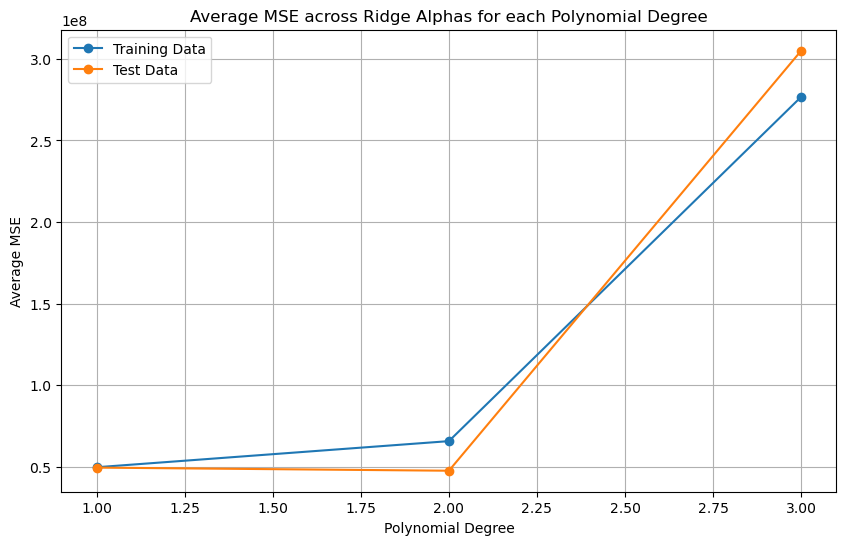

In [12]:
# Calculating the mean MSE for each param_poly__degree from both matrices
train_mse_means = mse_matrix.mean(axis=1)
test_mse_means = test_mse_matrix.mean(axis=1)

# Plotting the means for both training and test sets
plt.figure(figsize=(10, 6))
plt.plot(train_mse_means.index, train_mse_means.values, '-o', label='Training Data')
plt.plot(test_mse_means.index, test_mse_means.values, '-o', label='Test Data')

plt.xlabel('Polynomial Degree')
plt.ylabel('Average MSE')
plt.title('Average MSE across Ridge Alphas for each Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()
